# Baseline NLP Modeling Notebook

In [5]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers.keras_callbacks import KerasMetricCallback
import torch
from datasets import Dataset
from pprint import pprint

# DeepSeek - to avoid it asking for my API key midway
import os
wandb_api_key = "1a489be8947a5bbf94fcc41855e40beaab35312e"
os.environ['WANDB_API_KEY'] = wandb_api_key
# os.environ['WANDB_SILENT'] = 'true'  # Reduces output noise

# Imports to produce metrics and graphs for assessing model
import wandb # learning how to use it
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
# 2. Load Classification Dataset
from google.colab import drive
drive.mount('/content/drive')
file_path_drive = '/content/drive/MyDrive/BrainStation/ML Dream/takehome/security/classification_data.csv'
classification_df = pd.read_csv(file_path_drive)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
classification_df.head()

,id,text,label
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect
1,2,No significant side effects were observed duri...,Positive Outcome
2,3,Participants were monitored every two weeks.,Neutral Observation
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect
4,5,Patients were instructed to maintain a food di...,Neutral Observation


In [11]:
# check if dataset is balanced
label_counts = classification_df['label'].value_counts()
print("Class Distribution:")
print(label_counts)

"""
Adverse Effect         352
Neutral Observation    335
Positive Outcome       313
"""

Class Distribution:
label
Adverse Effect         352
Neutral Observation    335
Positive Outcome       313
Name: count, dtype: int64


'\nAdverse Effect         352\nNeutral Observation    335\nPositive Outcome       313\n'

In [12]:
# 3. Encode Labels
label_encoder = LabelEncoder()
classification_df['label_encoded'] = label_encoder.fit_transform(classification_df['label'])

# 4. Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    classification_df['text'].tolist(),
    classification_df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42
)

# 5. Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# 6. Dataset Class
torch.backends.cuda.matmul.allow_tf32 = True

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClassificationDataset(train_encodings, train_labels)
val_dataset = ClassificationDataset(val_encodings, val_labels)

# 7. Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

# 8a. Training Arguments
training_args = TrainingArguments(
    output_dir="/tmp/results", # default name of run on wandb.ai if run_name not specified
    eval_strategy="epoch", # changed evaluation_strategy="epoch" -> eval_strategy bc of DeepSeek, confirmed with: https://github.com/huggingface/setfit/issues/512
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1, # way too low
    weight_decay=0.01,
    logging_dir="/tmp/logs",
    logging_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    report_to="wandb",  # Explicitly tell it to use W&B (rec from DeepSeek)
    run_name="helix-classification_v1"  # Custom run name, specificy v1 for using default notebook
)

# 8b. Custom metrics function to pass to: Transformers Trainer method
# compute_metrics must take a EvalPrediction and return a dictionary string to metric values
def compute_metrics(pred):
    labels = pred.label_ids # label_ids (np.ndarray) — Targets to be matched.

    # DeepSeek helping me to understand the following line
    preds = pred.predictions.argmax(-1) # logit predictions (np.ndarray) — Predictions of the model.
    # Find the position of the highest number (most likely category) in each row
    # The last dimension is always the class scores, sowe look at (-1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'precision_macro': precision_score(labels, preds, average='macro'),
        'recall_macro': recall_score(labels, preds, average='macro')
    }

# 9. Trainer: https://huggingface.co/docs/transformers/en/main_classes/trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics # Added for metrics
)

# 10. Train
trainer.train()
history = trainer.state.log_history

# 11. Evaluation
metrics = trainer.evaluate()
pprint(metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.269400,0.223602,1.000000,1.000000,1.000000,1.000000


{'epoch': 1.0,
 'eval_accuracy': 1.0,
 'eval_f1_macro': 1.0,
 'eval_loss': 0.223601832985878,
 'eval_precision_macro': 1.0,
 'eval_recall_macro': 1.0,
 'eval_runtime': 4.6898,
 'eval_samples_per_second': 42.646,
 'eval_steps_per_second': 2.772}


## 11. Evaluation

https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html


Evaluation Metrics:
Validation Loss: 0.224
Validation Accuracy: 1.000
F1 Score: 1.000


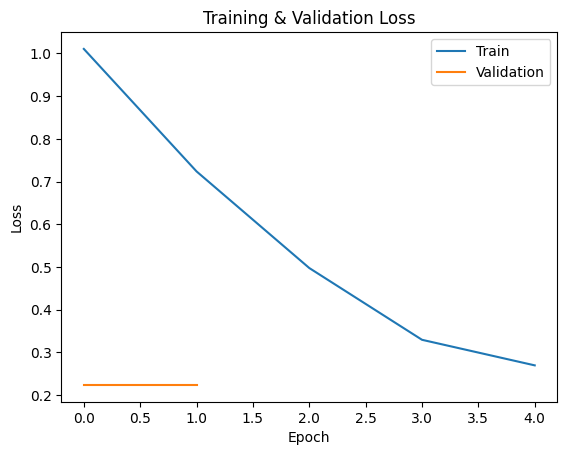

In [21]:
print("\nEvaluation Metrics:")
print(f"Validation Loss: {metrics['eval_loss']:.3f}")
print(f"Validation Accuracy: {metrics['eval_accuracy']:.3f}")
print(f"F1 Score: {metrics['eval_f1_macro']:.3f}")

# Extract metrics for plotting
train_loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
val_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
val_f1 = [x['eval_f1_macro'] for x in history if 'eval_f1_macro' in x]

# In-notebook plots
# plt.figure(figsize=(15, 5))

# Loss plot
# plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
# plt.subplot(1, 3, 2)
# plt.plot(val_acc, label='Validation')
# plt.title('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # F1 plot
# plt.subplot(1, 3, 3)
# plt.plot(val_f1, label='Validation')
# plt.title('Validation F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1 (Macro)')
# plt.legend()

# plt.tight_layout()
plt.show()

In [14]:
# Final evaluation
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

# Confusion Matrix - raw text
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(val_labels, preds)
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, preds, target_names=label_encoder.classes_))


Confusion Matrix:
[[72  0  0]
 [ 0 62  0]
 [ 0  0 66]]

Classification Report:
                     precision    recall  f1-score   support

     Adverse Effect       1.00      1.00      1.00        72
Neutral Observation       1.00      1.00      1.00        62
   Positive Outcome       1.00      1.00      1.00        66

           accuracy                           1.00       200
          macro avg       1.00      1.00      1.00       200
       weighted avg       1.00      1.00      1.00       200



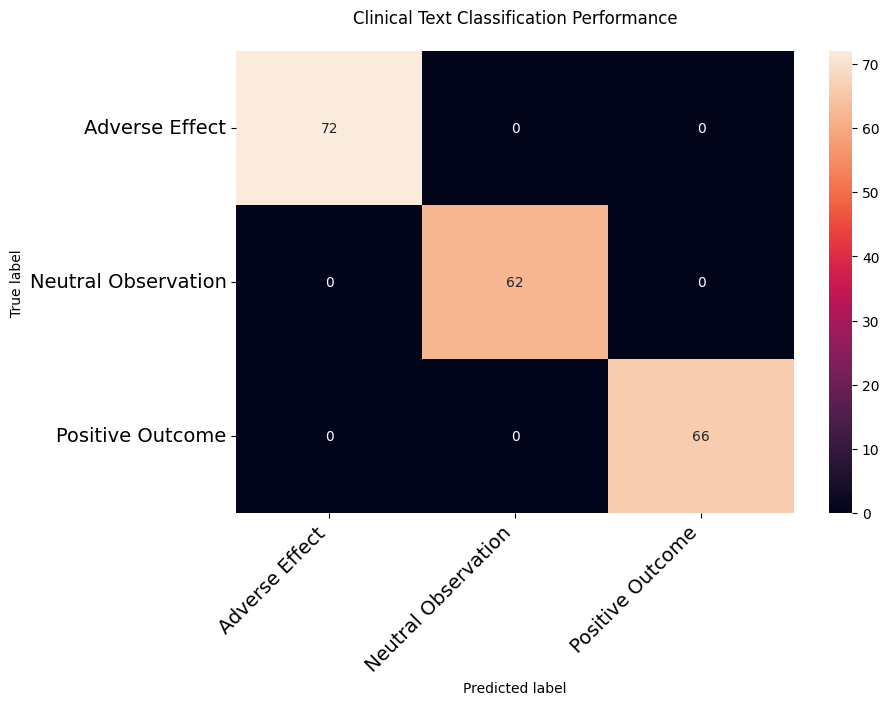

In [15]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Adverse Effect', 'Neutral Observation', 'Positive Outcome']
print_confusion_matrix(conf_matrix, class_names)
plt.title('Clinical Text Classification Performance', pad=20)
plt.show()

# Deliverable 4: Examples
- Show model predictions on at least 5 example sentences

In [16]:
# 12. Make predictions on sample text (DeepSeek generated)
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test predictions
sample_texts = [
    # AI generated examples
    "Patient reported severe nausea after medication administration.", # generated
    "The treatment resulted in significant improvement of symptoms.", # generated
    "Blood pressure was measured at 120/80 mmHg.", # generated

    # Modified AI generated examples
    "Patient reported nausea after medication administration.", # removed word 'severe' to see if it can still guess ADVERSE
    "Patient avoided severe complications after medication administration.", # try 'AVOID SEVERE' together, misclassified
    "The treatment resulted in improvement of symptoms.", # removed word 'significant'to see if it can still guess POSITIVE
]

print("\nSample Predictions:")
for text in sample_texts:
    print(f"Text: {text}")
    print(f"Prediction: {predict(text)}\n")


Sample Predictions:
Text: Patient reported severe nausea after medication administration.
Prediction: Adverse Effect

Text: Patient reported nausea after medication administration.
Prediction: Adverse Effect

Text: Patient avoided severe complications after medication administration.
Prediction: Adverse Effect

Text: The treatment resulted in significant improvement of symptoms.
Prediction: Positive Outcome

Text: The treatment resulted in improvement of symptoms.
Prediction: Positive Outcome

Text: Blood pressure was measured at 120/80 mmHg.
Prediction: Neutral Observation



## Try it yourself with your own sentences

In [22]:
# Test predictions
sample_texts_custom = [
    "Irrelevant text."
]

print("\nSample Predictions:")
for text in sample_texts_custom:
    print(f"Text: {text}")
    print(f"Prediction: {predict(text)}\n")


Sample Predictions:
Text: Irrelevant text.
Prediction: Neutral Observation

